# YOLO Fine-tuning for symbol detection via Synthetic Dataset

**code based on other generic yolo fine-tuners**

-Chenghao Li

In [1]:
!nvidia-smi

Tue Jan  6 07:26:14 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   46C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!pip install ultralytics -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 49.2 MB/s eta 0:00:00


Setting up drive mounting

In [6]:
from google.colab import drive
drive.mount('/content/drive')
!cp /content/drive/MyDrive/dataset.zip .
!unzip -q dataset.zip -d dataset

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
replace dataset/dataset/dataset.yaml? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace dataset/dataset/images/train/synthetic_00000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace dataset/dataset/images/train/synthetic_00001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace dataset/dataset/images/train/synthetic_00001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: an
error:  invalid response [an]
replace dataset/dataset/images/train/synthetic_00001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


Getting config

In [11]:
import yaml

yaml_path = 'dataset/dataset/dataset.yaml'

with open(yaml_path, 'r') as f:
    config = yaml.safe_load(f)

config['path'] = '/content/dataset/dataset'
config['train'] = 'images/train'
config['val'] = 'images/val'

with open(yaml_path, 'w') as f:
    yaml.dump(config, f, default_flow_style=False)

print("Updated dataset.yaml:")
print(yaml.dump(config, default_flow_style=False))

Updated dataset.yaml:
names:
  0: bowtie
  1: keynote
  2: T_Symbol
nc: 3
path: /content/dataset/dataset
train: images/train
val: images/val



## TRAINING CONFIG

In [1]:
MODEL = "yolov8n.pt"
EPOCHS = 50
BATCH_SIZE = 16
IMG_SIZE = (1000, 1416)
PATIENCE = 10

## Training

In [2]:
from ultralytics import YOLO

model = YOLO(MODEL)

results = model.train(
    data='dataset/dataset/dataset.yaml',
    epochs=EPOCHS,
    batch=BATCH_SIZE,
    imgsz=IMG_SIZE,
    patience=PATIENCE,
    device=0,
    project='runs',
    name='symbol_detector',
    exist_ok=True,
    pretrained=True,
    verbose=True
)

Ultralytics 8.3.248 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset/dataset/dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=(1000, 1416), int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=symbol_detector, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, perspective=0.0, plot

## Results vis


results.png:


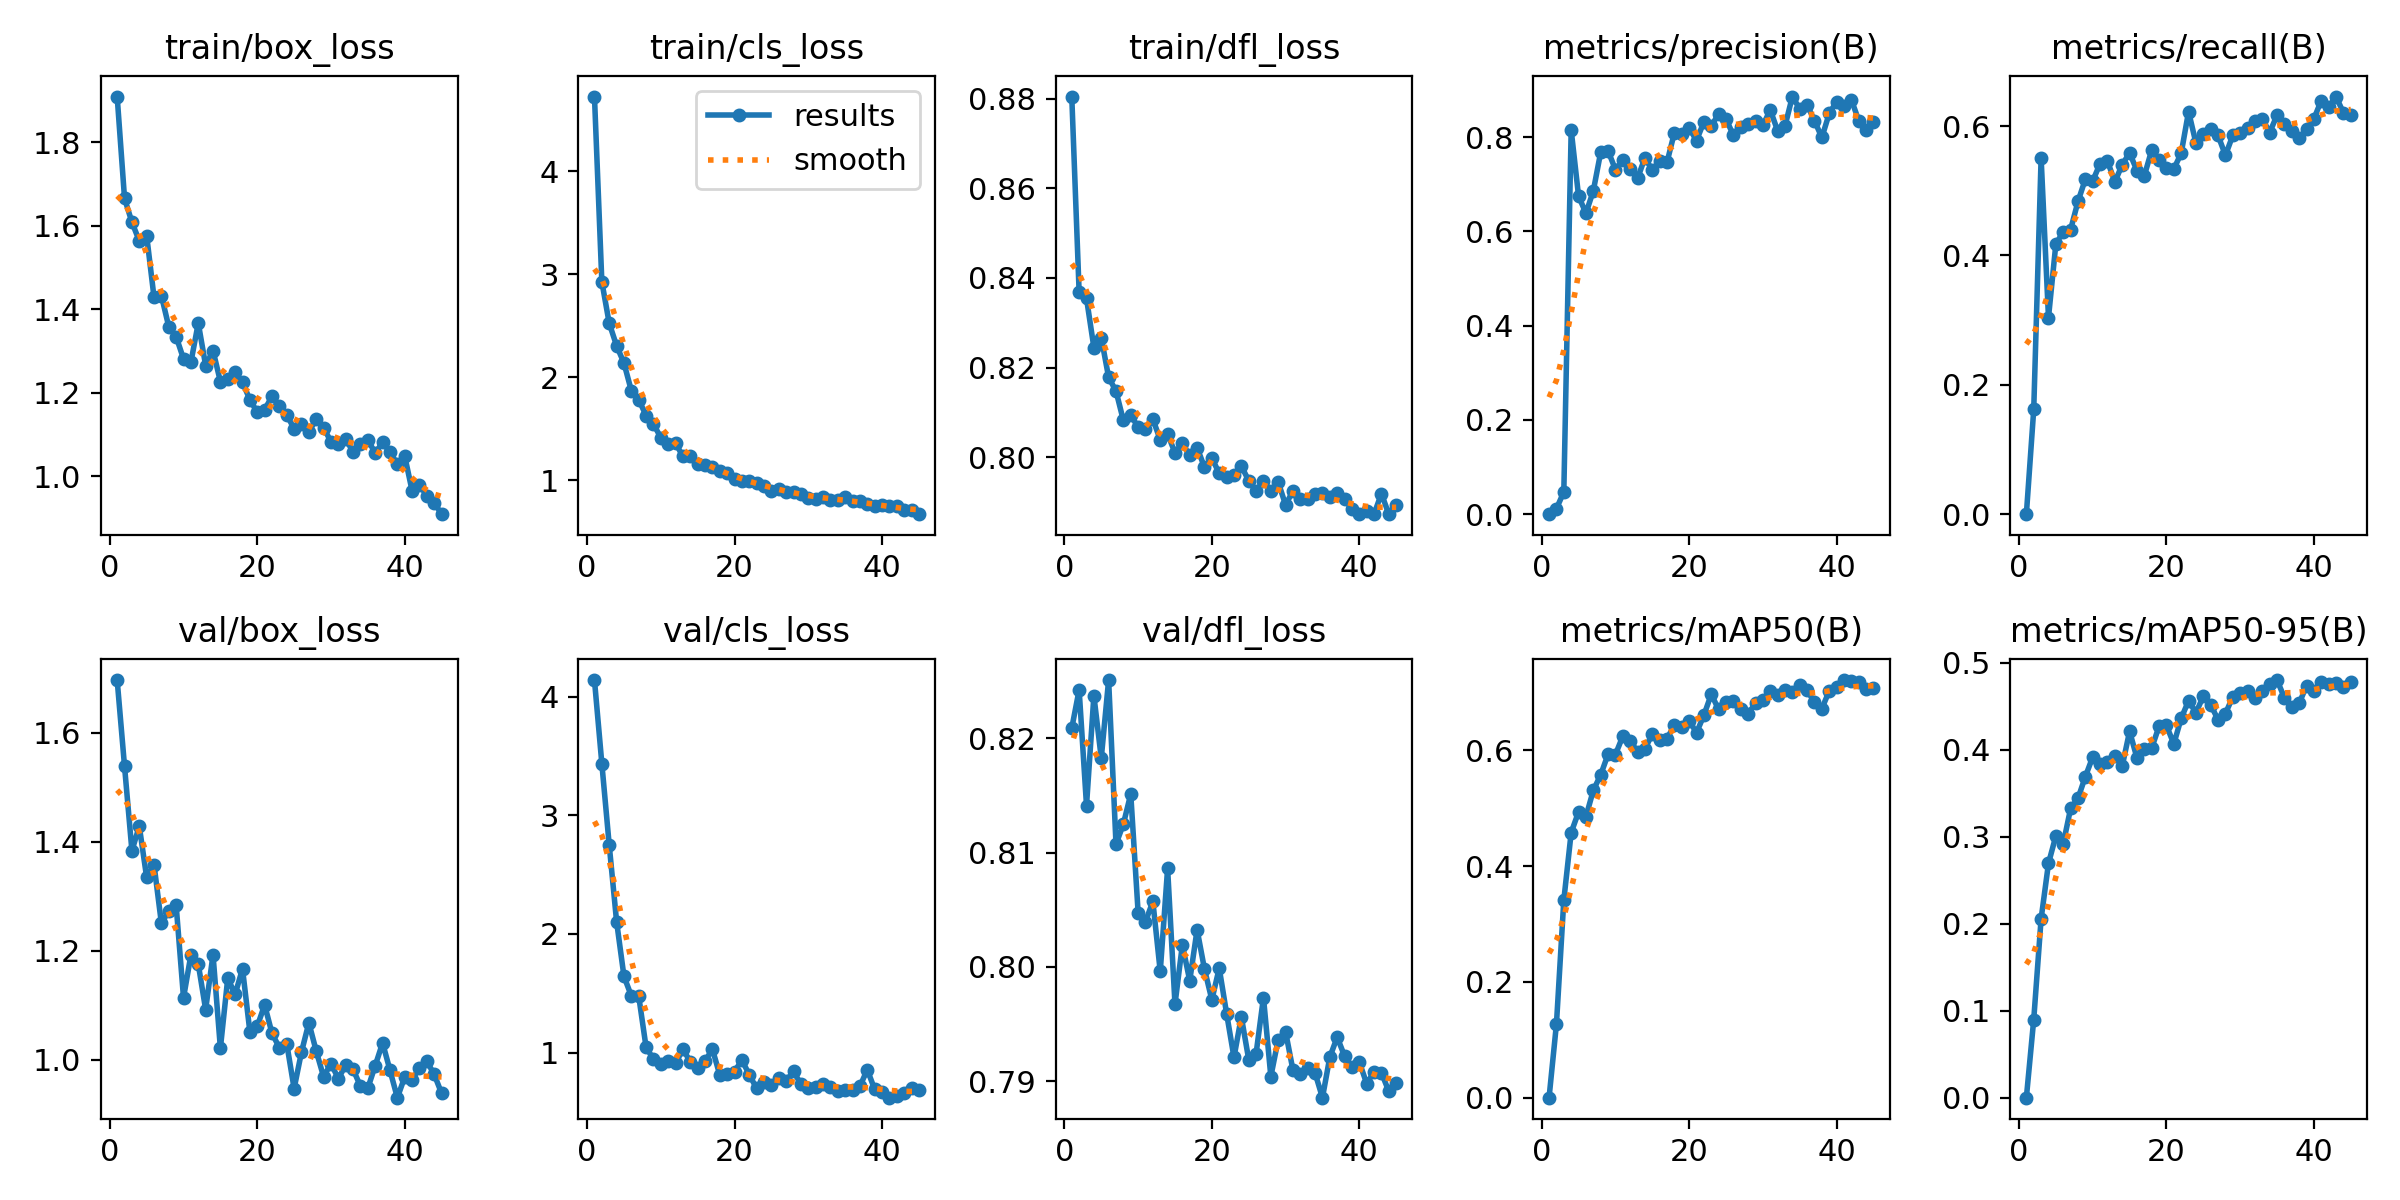


confusion_matrix.png:


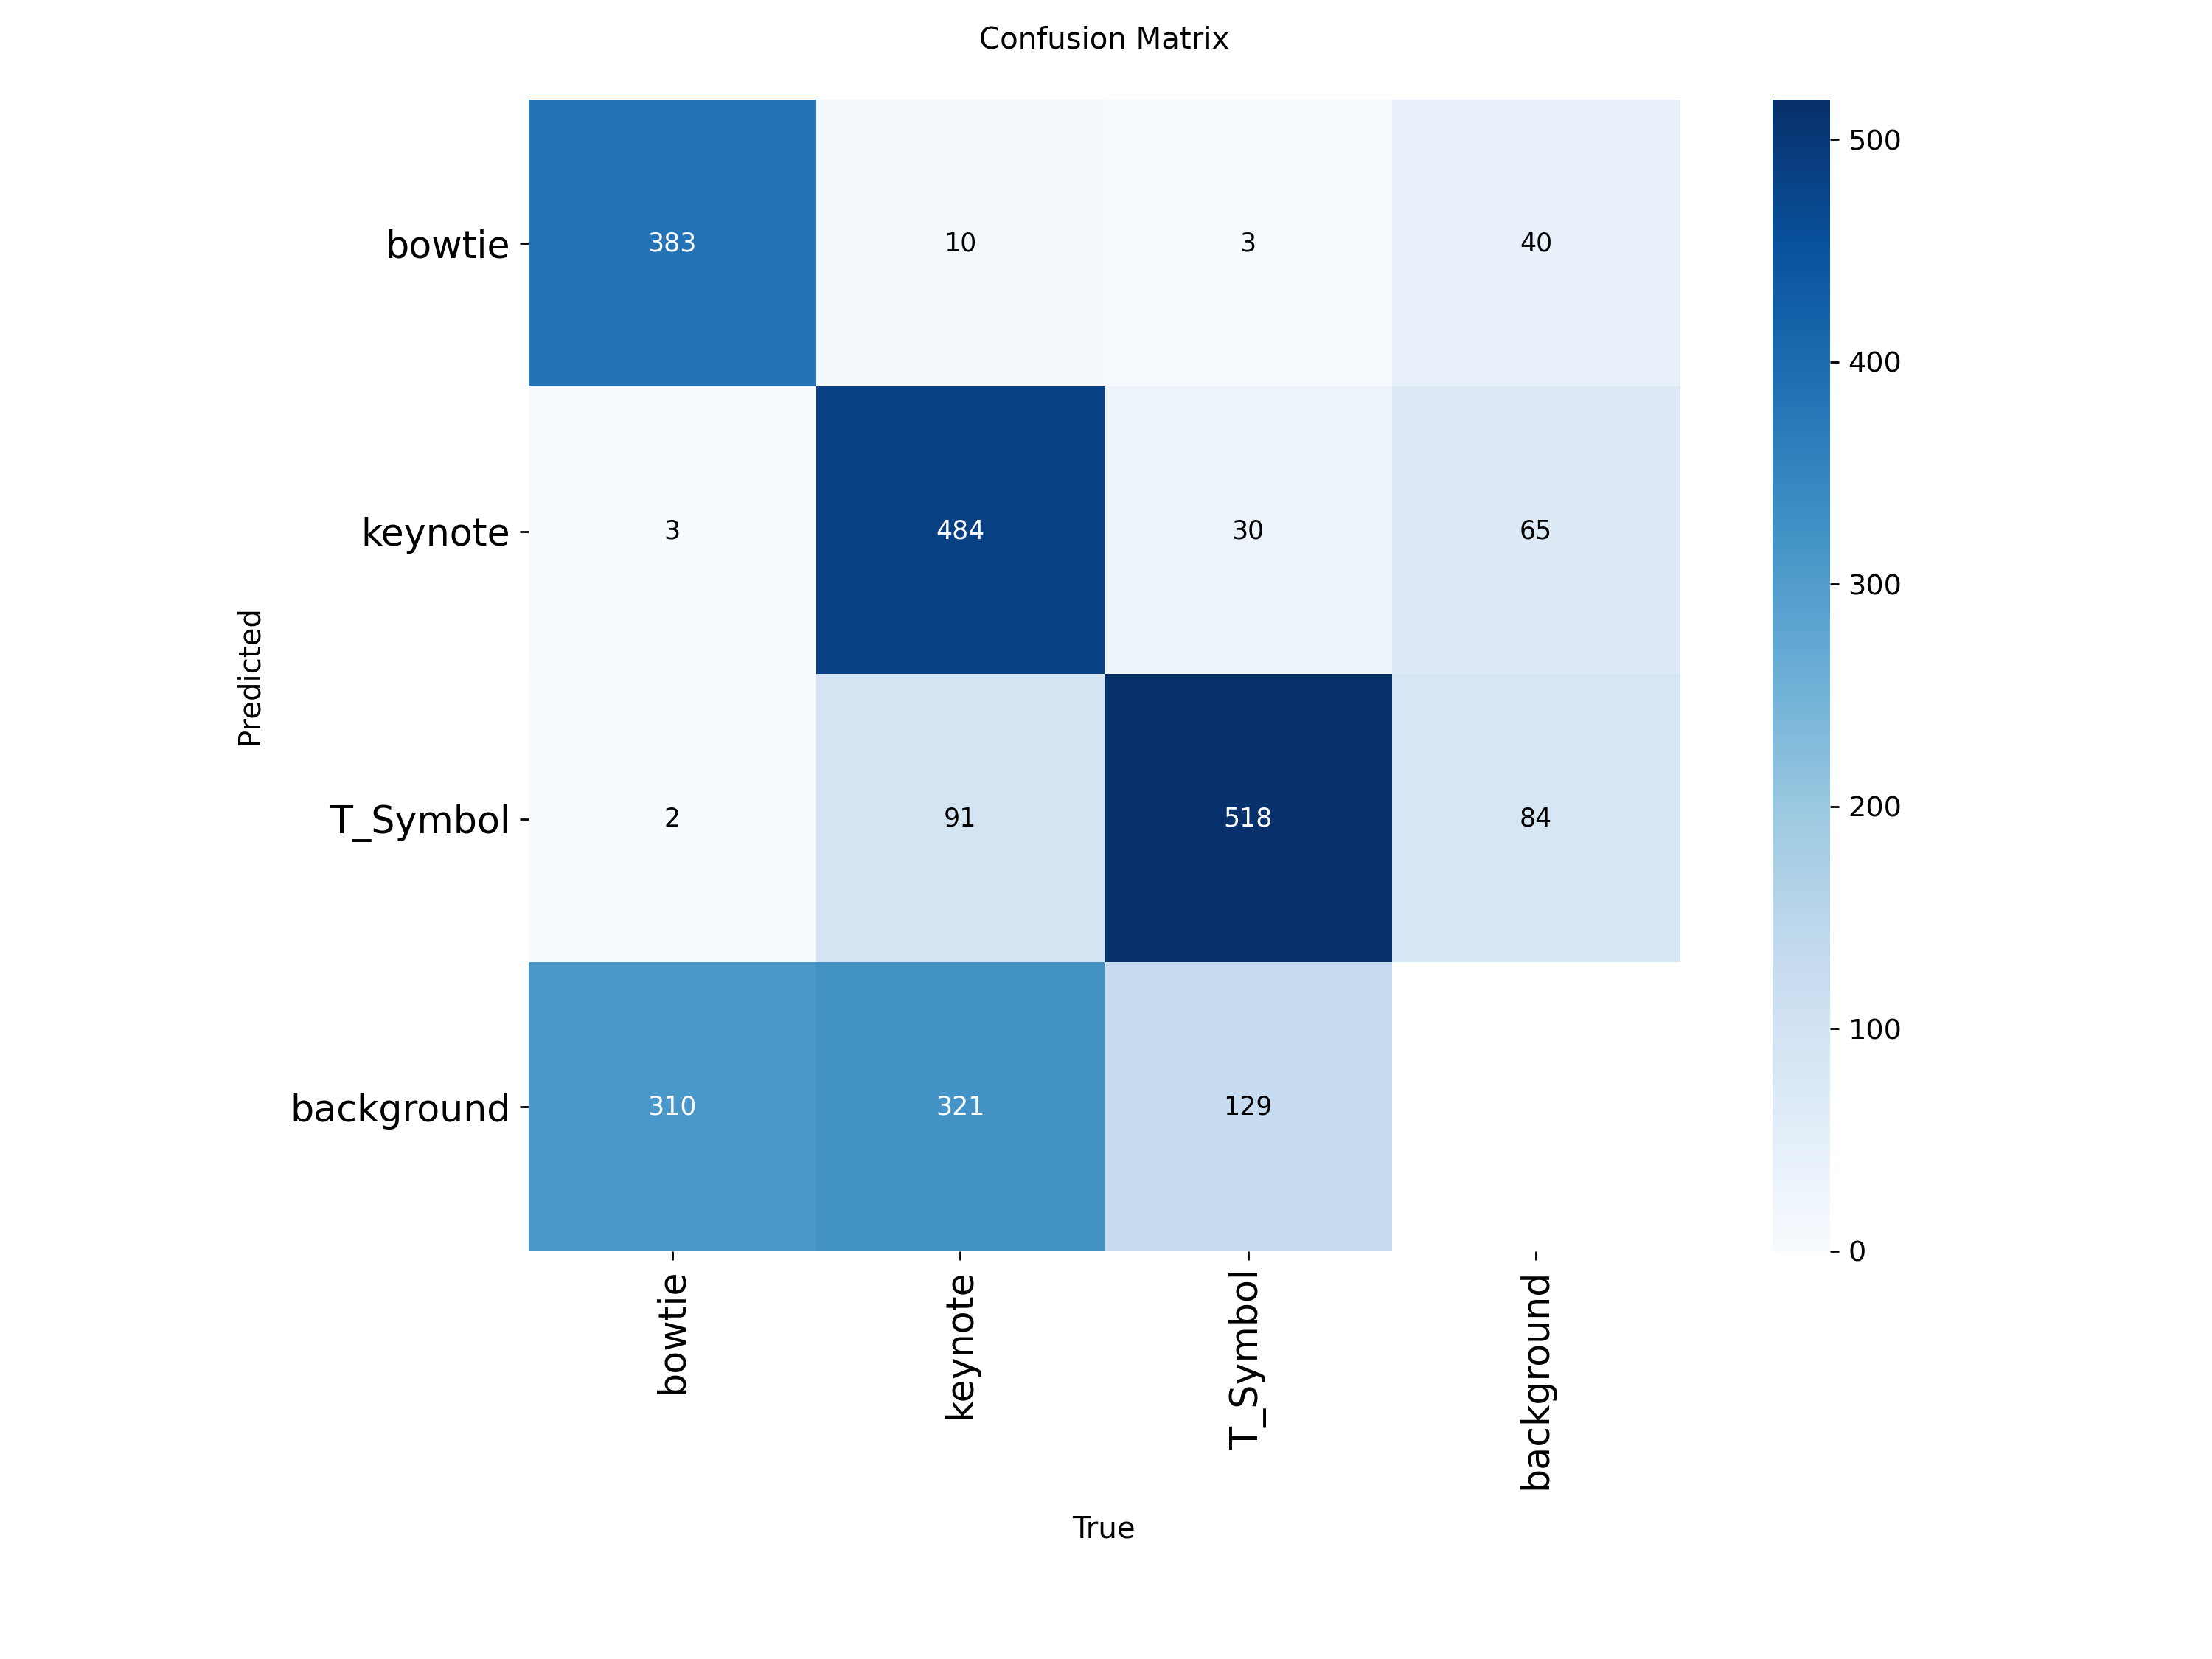

In [4]:
from IPython.display import Image, display
import glob
import os

results_dir = 'runs/symbol_detector'

for img_path in ['results.png', 'confusion_matrix.png', 'val_batch0_pred.png']:
    full_path = f'{results_dir}/{img_path}'
    if os.path.exists(full_path):
        print(f"\n{img_path}:")
        display(Image(filename=full_path))

## Exporting Model

In [5]:
best_model = YOLO('runs/symbol_detector/weights/best.pt')
best_model.export(format='onnx')

print("\nExported to ONNX!")

Ultralytics 8.3.248 🚀 Python-3.12.12 torch-2.9.0+cu126 CPU (Intel Xeon CPU @ 2.00GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from 'runs/symbol_detector/weights/best.pt' with input shape (1, 3, 1440, 1440) BCHW and output shape(s) (1, 7, 42525) (6.1 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0,<2.0.0', 'onnxslim>=0.1.71', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
Using Python 3.12.12 environment at: /usr
Resolved 14 packages in 343ms
Prepared 6 packages in 4.54s
Installed 6 packages in 383ms
 + colorama==0.4.6
 + coloredlogs==15.0.1
 + humanfriendly==10.0
 + onnx==1.20.0
 + onnxruntime-gpu==1.23.2
 + onnxslim==0.1.82

requirements: AutoUpdate success ✅ 6.0s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


ONNX: starting expor

/usr/local/lib/python3.12/dist-packages/torch/onnx/_internal/torchscript_exporter/utils.py:1447: OnnxExporterWarning: Exporting to ONNX opset version 22 is not supported. by 'torch.onnx.export()'. The highest opset version supported is 20. To use a newer opset version, consider 'torch.onnx.export(..., dynamo=True)'. 
  warnings.warn(


ONNX: slimming with onnxslim 0.1.82...
ONNX: export success ✅ 8.1s, saved as 'runs/symbol_detector/weights/best.onnx' (12.4 MB)

Export complete (9.5s)
Results saved to /content/runs/symbol_detector/weights
Predict:         yolo predict task=detect model=runs/symbol_detector/weights/best.onnx imgsz=1440  
Validate:        yolo val task=detect model=runs/symbol_detector/weights/best.onnx imgsz=1440 data=dataset/dataset/dataset.yaml  
Visualize:       https://netron.app

Exported to ONNX!


In [11]:

import shutil
shutil.make_archive('trained_model', 'zip', 'runs/symbol_detector/weights')

'/content/trained_model.zip'

## Example inference

Testing on: dataset/dataset/images/val/synthetic_00483.jpg

image 1/1 /content/dataset/dataset/images/val/synthetic_00483.jpg: 1024x1440 4 bowties, 4 keynotes, 10 T_Symbols, 39.0ms
Speed: 11.8ms preprocess, 39.0ms inference, 4.0ms postprocess per image at shape (1, 3, 1024, 1440)
Results saved to /content/runs/test_inference


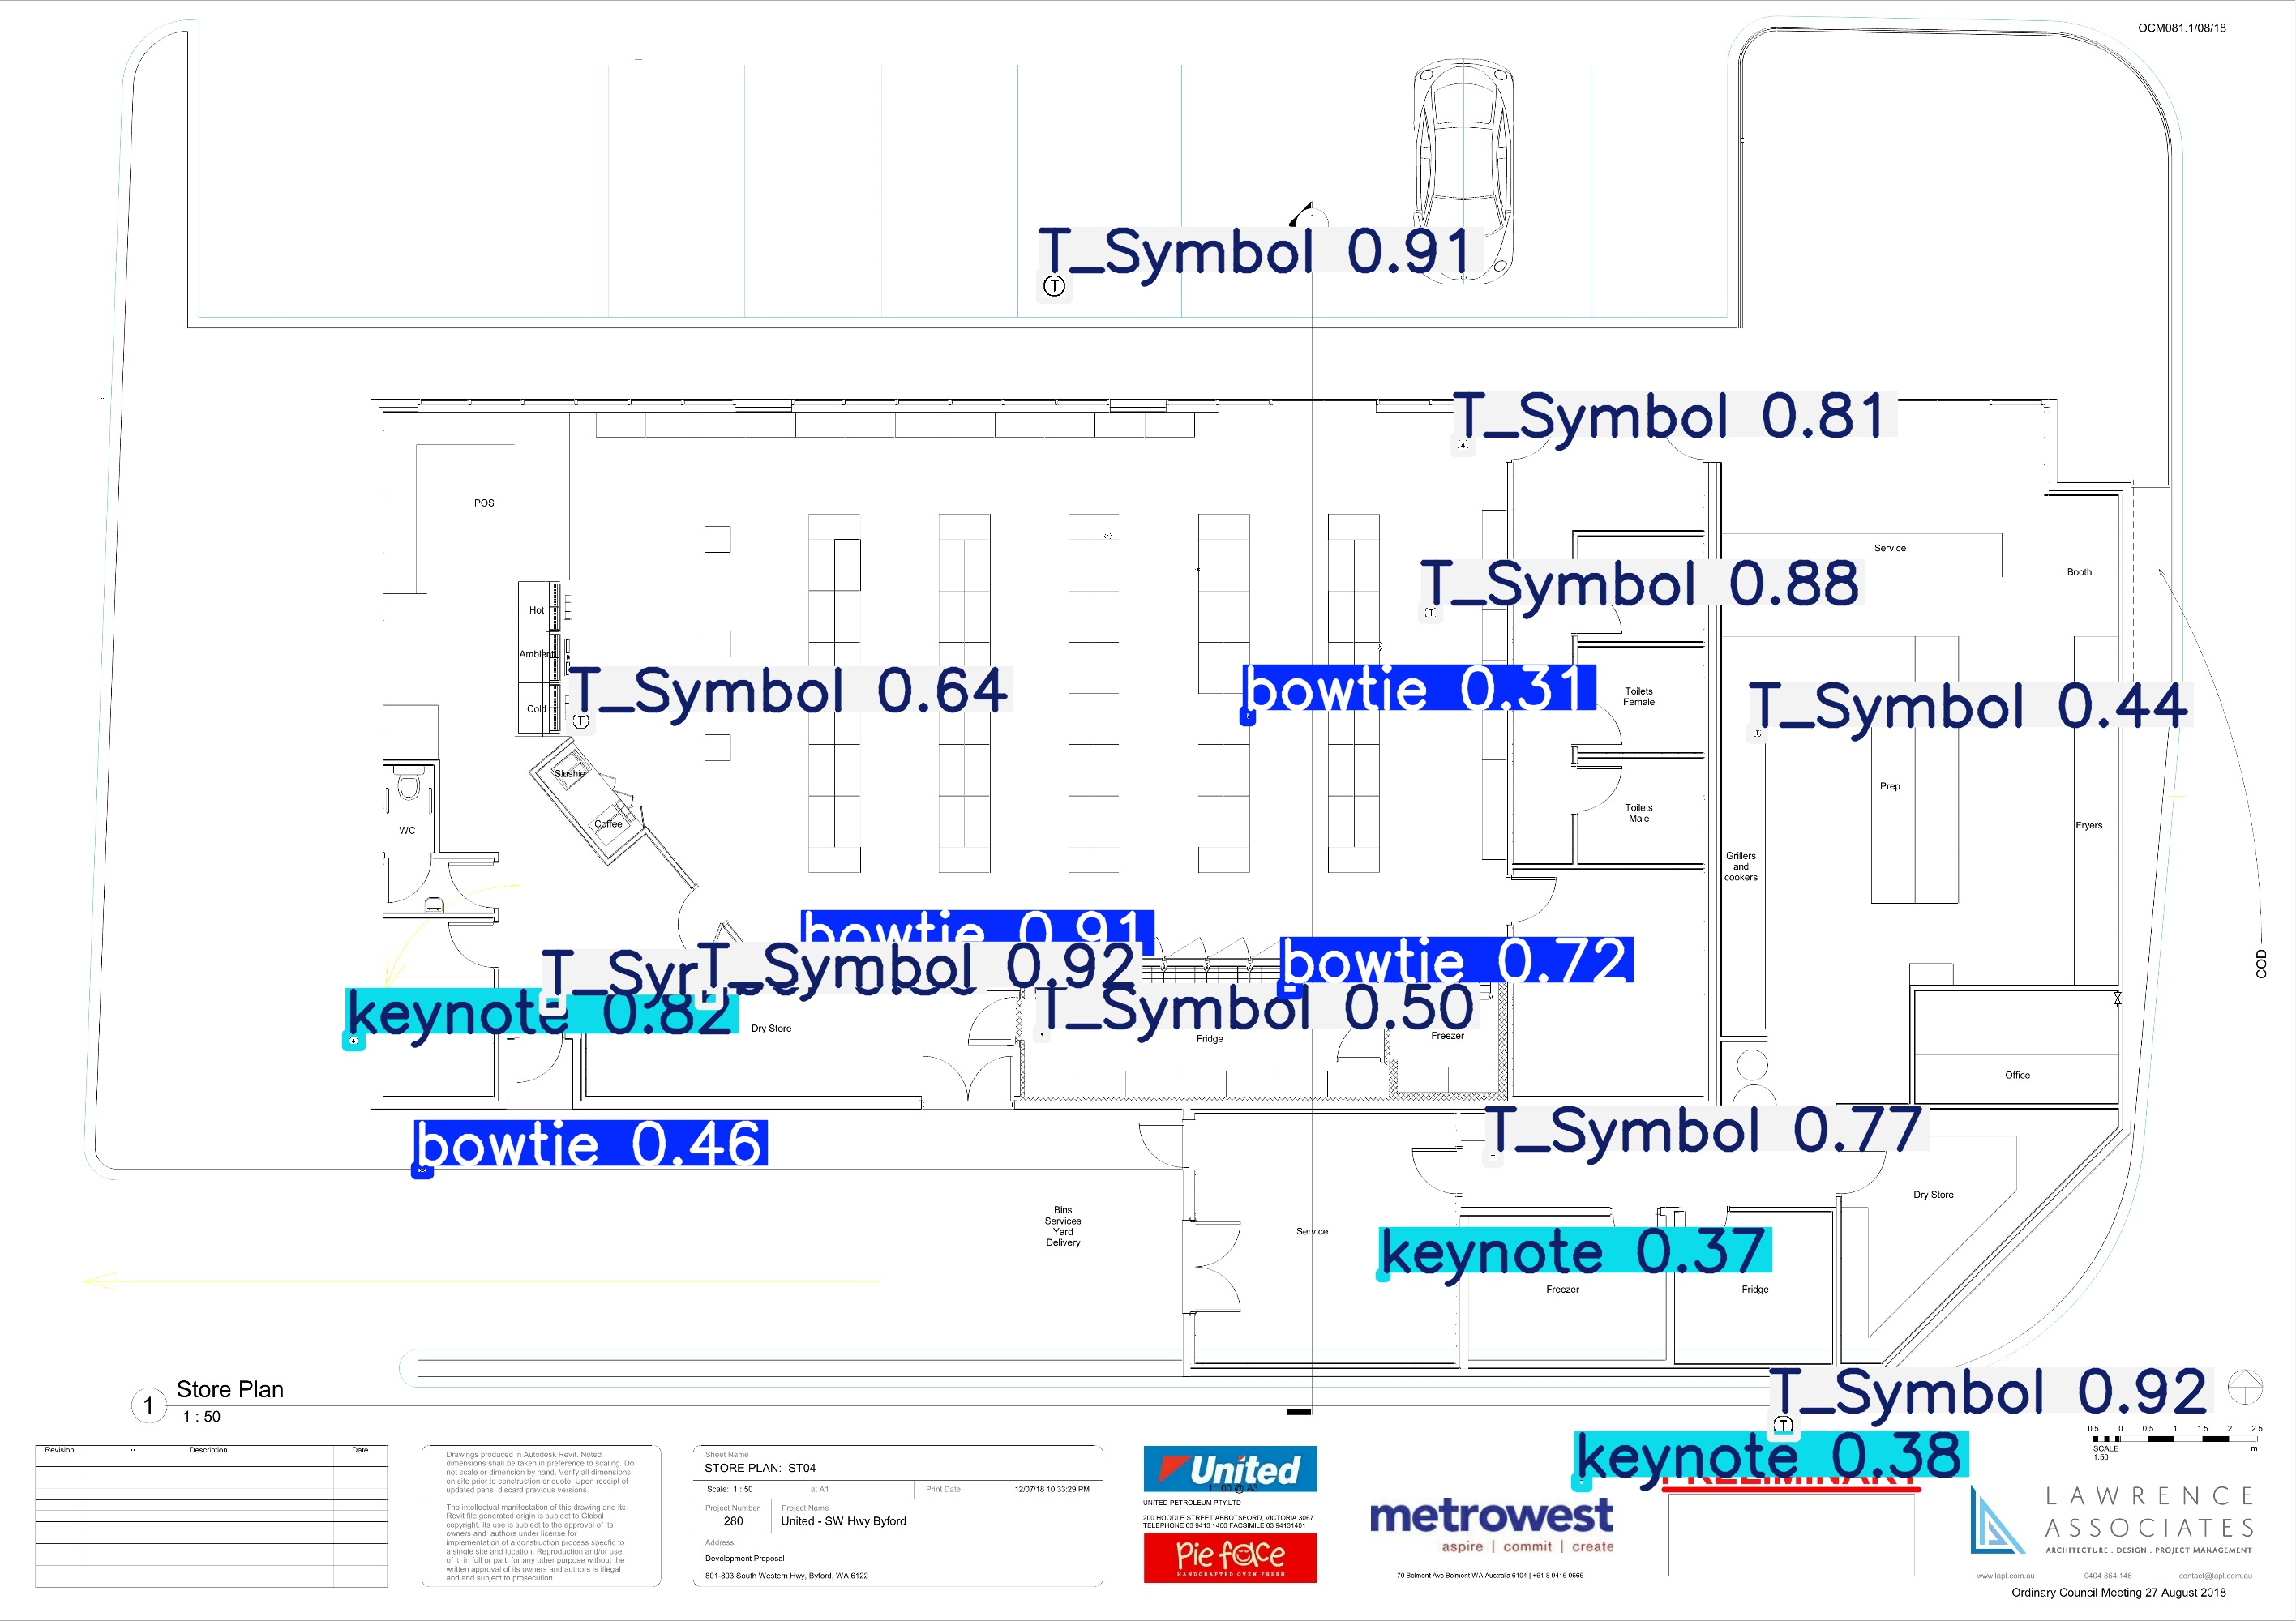

In [10]:
import glob

val_images = glob.glob('dataset/dataset/images/val/*.jpg')
if val_images:
    test_img = val_images[0]
    print(f"Testing on: {test_img}")

    results = best_model.predict(test_img, save=True, project='runs', name='test_inference')

    pred_img = glob.glob('runs/test_inference/*.jpg')[0]
    display(Image(filename=pred_img))
else:
    print("No validation images found")